In [2]:
import torch
from data_handler import DataHandler, load_encoded_data, load_json, save_json
from model import TravelDocClassifier
from cuda_utils import clear_cache, print_cuda_memory_info

In [8]:
clear_cache()
print_cuda_memory_info()

Device: NVIDIA GeForce GTX 1660 Ti
Total Memory: 6.44 GB
Reserved Memory: 0.47 GB
Allocated Memory: 0.42 GB
Free Memory: 0.05 GB


### Testing

In [9]:
data_handler = DataHandler(tokenizer_name='bert-base-chinese')

encodings, labels = load_encoded_data('encoded_data/test')

test_dataset = data_handler.create_dataset(encodings, labels)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = TravelDocClassifier(device=device, params_path='parameters/20240513_fold_3_model_parameters.pth')
test_accuracy, confusion = classifier.test(test_dataset)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(confusion)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.61%
Confusion Matrix:
[[ 745 2143]
 [1982 5833]]


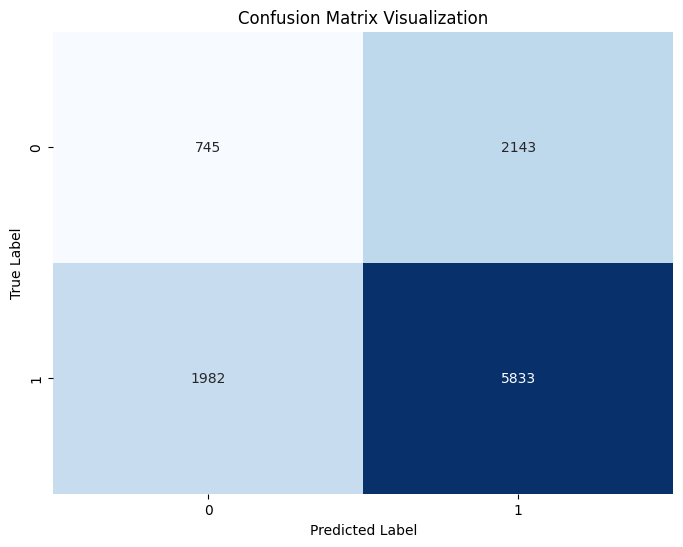

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 的 heatmap 函數來創建熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

# 加入標籤和標題
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Visualization')
plt.show()

In [12]:
tp, fn, fp, tn = confusion.ravel()

# 精確率 (Precision)
precision = tp / (tp + fp)

# 召回率 (Recall)
recall = tp / (tp + fn)

# 特異性 (Specificity)
specificity = tn / (tn + fp)

print(f"精確率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"特異性 (Specificity): {specificity:.4f}")

精確率 (Precision): 0.2732
召回率 (Recall): 0.2580
特異性 (Specificity): 0.7464


### Prediction

In [3]:
filtered_data = load_json('filtered_data/all.json')

In [4]:
data_handler = DataHandler(tokenizer_name='bert-base-chinese')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

travel_related = []
non_travel_related = []

for doc in filtered_data:
    content = doc['content']
    input = data_handler.prepare_input_for_prediction(content)

    classifier = TravelDocClassifier(device=device, params_path='parameters/20240513_fold_3_model_parameters.pth')
    pred_label = classifier.predict(input)

    if pred_label == 1:
        travel_related.append(doc)
    else:
        non_travel_related.append(doc)

len(travel_related), len(non_travel_related)

c:\Users\a9542\Desktop\programes\information_retrieval\final\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoin

KeyboardInterrupt: 

In [ ]:
save_json(travel_related, 'results/travel_related_predictions.json')
save_json(non_travel_related, 'results/non_travel_related_predictions.json')